# Basic setup

## preprocessing

In [2]:
#!pip install datasets transformers scikit-learn

In [90]:
import json
import pandas as pd
from datasets import Dataset
import transformers
from transformers import AutoTokenizer, AutoModel
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer

In [92]:

train_files = [
    "../data/eng-danc.json",
    "../data/eng-fina.json",
    "../data/eng-nava.json",
    "../data/eng-redh.json",
    "../data/eng-scan.json",
    "../data/eng-spec.json"
]
    
test_file = "../data/eng-houn.json"

In [102]:
def extract_words_and_sentiments(data):
    """
    Transforms a JSON data object into a list of [words, sentiment_labels] pairs.
    Sentiment is assigned to tokens based on the 'wids' from the concept data.
    Tokens not associated with any concept get a sentiment of 0.
    """
    transformed_data = []

    for sentence in data.get("sentences", []):
        words = sentence.get("words", [])
        concepts = sentence.get("concepts", [])

        word_list = [w["word"] for w in words]
        sentiment_list = ["NEUTRAL"] * len(words)  # initialize all sentiments as neutral (0)

        # map word id to index in words list
        wid_to_index = {w["wid"]: idx for idx, w in enumerate(words)}

        for concept in concepts:
            if "sentiment" in concept and "wids" in concept:
                sentiment = concept["sentiment"]

                if sentiment <= -20:
                    simple_sentiment = "NEGATIVE"
                elif sentiment >= 20:
                    simple_sentiment = "POSITIVE"
                else:
                    simple_sentiment = "NEUTRAL"

                for wid in concept["wids"]:
                    idx = wid_to_index.get(wid)
                    if idx is not None:
                        sentiment_list[idx] = simple_sentiment

        transformed_data.append([word_list, sentiment_list])

    return transformed_data


In [134]:
combined_train_list = []

for file in train_files:
    with open(file, "r") as f:
        data = json.load(f)
        transformed = extract_words_and_sentiments(data)
        combined_train_list.extend(transformed)

In [135]:
with open(test_file, "r") as f:
    test_data = json.load(f)
    
test_list = extract_words_and_sentiments(test_data)
combined_train_list[0]

[['The', 'Adventure', 'of', 'the', 'Dancing', 'Men'],
 ['NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL', 'NEUTRAL']]

In [137]:
df_train = pd.DataFrame(combined_train_list, columns=['tokens', 'sentiment_label'])
df_test = pd.DataFrame(test_list, columns=['tokens', 'sentiment_label'])
print(df_train.head())

                                              tokens  \
0            [The, Adventure, of, the, Dancing, Men]   
1  [Holmes, had, been, seated, for, some, hours, ...   
2  [His, head, was, sunk, upon, his, breast, ,, a...   
3  [", So, ,, Watson, ,, ", said, he, ,, suddenly...   
4           [I, gave, a, start, of, astonishment, .]   

                                     sentiment_label  
0  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
1  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
2  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
3  [NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, NEUTRAL, ...  
4  [NEUTRAL, NEUTRAL, NEUTRAL, NEGATIVE, NEUTRAL,...  


In [139]:
label_map = {"NEGATIVE": 0, "NEUTRAL": 1, "POSITIVE": 2}

df_train["sentiment_label"] = df_train["sentiment_label"].apply(
    lambda labels: [label_map[label] for label in labels])

def filter_and_binarize_positive_sentences(df, min_positive=3):
    filtered_rows = []

    for _, row in df.iterrows():
        labels = row["sentiment_label"]
        num_positive = sum(1 for label in labels if label == 2)

        if num_positive > min_positive:
            new_labels = [1 if label == 2 else 0 for label in labels]  # Binary relabeling
            filtered_rows.append({"tokens": row["tokens"], "sentiment_label": new_labels})

    return pd.DataFrame(filtered_rows)

df_train = filter_and_binarize_positive_sentences(df_train, min_positive=3)

df_test["sentiment_label"] = df_test["sentiment_label"].apply(
    lambda labels: [label_map[label] for label in labels])


In [142]:
df_test = df_train.sample(n=50, random_state=42).reset_index(drop=True)

dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)
print(dataset_train[3])

{'tokens': ['"', 'You', 'gave', 'me', 'a', 'few', 'particulars', 'in', 'your', 'letter', ',', 'Mr.', 'Hilton', 'Cubitt', ',', 'but', 'I', 'should', 'be', 'very', 'much', 'obliged', 'if', 'you', 'would', 'kindly', 'go', 'over', 'it', 'all', 'again', 'for', 'the', 'benefit', 'of', 'my', 'friend', ',', 'Dr.', 'Watson', '.', '"'], 'sentiment_label': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]}


In [144]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [146]:
label_all_tokens = True

In [148]:
def tokenize_and_align_labels(batch, label_all_tokens=True):
    tokenized_inputs = tokenizer(batch["tokens"], truncation=True, is_split_into_words=True)

    all_labels = []

    for i, word_ids in enumerate(tokenized_inputs.word_ids(batch_index=i) for i in range(len(batch["tokens"]))):
        word_labels = batch["sentiment_label"][i]
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(word_labels[word_idx])
            else:
                label_ids.append(word_labels[word_idx] if label_all_tokens else -100)

            previous_word_idx = word_idx

        all_labels.append(label_ids)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs


In [150]:
tokenize_and_align_labels(dataset_train[:3])

{'input_ids': [[101, 1000, 1045, 11276, 2000, 2191, 2017, 3696, 1037, 3259, 2000, 2008, 3466, 1012, 1000, 102], [101, 1037, 3082, 3357, 2001, 2657, 2588, 1996, 5108, 1010, 1998, 2019, 7107, 2101, 2045, 3133, 1037, 4206, 1010, 25298, 2100, 1010, 4550, 1011, 27545, 2078, 10170, 1010, 3005, 3154, 2159, 1998, 13109, 10050, 2094, 6029, 2409, 1997, 1037, 2166, 2419, 2521, 2013, 1996, 9666, 2015, 1997, 6243, 2395, 1012, 102], [101, 2002, 2790, 2000, 3288, 1037, 1059, 25798, 1997, 2010, 2844, 1010, 4840, 1010, 25919, 1010, 2264, 1011, 3023, 2250, 2007, 2032, 2004, 2002, 3133, 1012, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [154]:
tokenized_training_dataset = dataset_train.map(tokenize_and_align_labels, batched=True)
tokenized_test_small = dataset_test.map(tokenize_and_align_labels, batched=True)
#tokenized_test_dataset = dataset_test.map(tokenize_and_align_labels, batched=True)

Map: 100%|█████████████████████████████| 50/50 [00:00<00:00, 4754.15 examples/s]


In [156]:
tokenized_training_dataset[0]

{'tokens': ['"',
  'I',
  'ought',
  'to',
  'make',
  'you',
  'sign',
  'a',
  'paper',
  'to',
  'that',
  'effect',
  '.',
  '"'],
 'sentiment_label': [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0],
 'input_ids': [101,
  1000,
  1045,
  11276,
  2000,
  2191,
  2017,
  3696,
  1037,
  3259,
  2000,
  2008,
  3466,
  1012,
  1000,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, -100]}

## model training

In [32]:
#!pip install evaluate
#!pip install seqeval
#!pip install torch
#!pip install "accelerate>=0.26.0"

In [158]:
import evaluate
import numpy as np
model_checkpoint = "bert-base-uncased"
task = "sentiment_analysis"
batch_size = 16

In [160]:
from transformers import set_seed

#put your seed
SEED = 123
set_seed(SEED)
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    eval_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

In [162]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load("seqeval")
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [163]:
label_list = ["NEGATIVE", "POSITIVE"] 

In [164]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [168]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_training_dataset,
    eval_dataset=tokenized_test_small, #write test
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/var/folders/pk/23rj3vrj73x83046rkqn9g100000gn/T/ipykernel_2232/913721409.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [170]:
trainer.train()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.388872,0.000000,0.000000,0.000000,0.869927
2,No log,0.346246,0.000000,0.000000,0.000000,0.869927
3,No log,0.327568,0.000000,0.000000,0.000000,0.869927


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=21, training_loss=0.423744383312407, metrics={'train_runtime': 25.7666, 'train_samples_per_second': 11.294, 'train_steps_per_second': 0.815, 'total_flos': 13118424085740.0, 'train_loss': 0.423744383312407, 'epoch': 3.0})

In [172]:
trainer.save_model('BERT_positive_model')
trainer.tokenizer.save_pretrained('BERT_positive_model')

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('BERT_positive_model/tokenizer_config.json',
 'BERT_positive_model/special_tokens_map.json',
 'BERT_positive_model/vocab.txt',
 'BERT_positive_model/added_tokens.json',
 'BERT_positive_model/tokenizer.json')

In [174]:
model = AutoModelForTokenClassification.from_pretrained("BERT_positive_model")
tokenizer = AutoTokenizer.from_pretrained("BERT_positive_model")

In [176]:
trainer.evaluate()

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.3275682032108307,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_accuracy': 0.8699266503667482,
 'eval_runtime': 0.7708,
 'eval_samples_per_second': 64.87,
 'eval_steps_per_second': 5.19,
 'epoch': 3.0}

In [178]:
predictions, labels, _ = trainer.predict(tokenized_test_small) #data set
predictions = np.argmax(predictions, axis=2)

/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: NEGATIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: POSITIVE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## model evaluation

In [259]:
#!pip install matplotlib

In [180]:
def map_predictions_to_words_and_save_to_file(predictions, labels, tokenized_dataset, output_file_path):
    import csv
    import numpy as np

    with open(output_file_path, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file, delimiter='\t')
        writer.writerow(['word', 'prediction', 'gold_label'])

        new_tokens = []
        new_labels = []
        new_predictions = []

        for idx, (prediction, label) in enumerate(zip(predictions, labels)):
            tokens = tokenized_dataset["tokens"][idx]
            input_ids = tokenized_dataset["input_ids"][idx]

            # Re-tokenize to get word_ids
            tokenized = tokenizer(tokens, truncation=True, is_split_into_words=True, return_tensors="pt")
            word_ids = tokenized.word_ids(batch_index=0)

            word_predictions = {}
            word_labels = {}

            for token_idx, word_idx in enumerate(word_ids):
                if word_idx is None:
                    continue  # Skip special tokens

                if word_idx not in word_predictions:
                    word_predictions[word_idx] = []
                word_predictions[word_idx].append(prediction[token_idx])

                if label[token_idx] != -100:
                    word_labels[word_idx] = label[token_idx]

            for word_idx in sorted(word_predictions.keys()):
                pred_id = np.argmax(np.bincount(word_predictions[word_idx]))
                predicted_label = label_list[pred_id]

                gold_label = label_list[word_labels[word_idx]] if word_idx in word_labels else "O"

                word_tokens = [
                    tokenizer.convert_ids_to_tokens(input_ids[i])
                    for i, w_idx in enumerate(word_ids) if w_idx == word_idx
                ]
                word = tokenizer.convert_tokens_to_string(word_tokens).strip()

                new_tokens.append(word)
                new_predictions.append(predicted_label)
                new_labels.append(gold_label)

                writer.writerow([word, predicted_label, gold_label])

    print(f"Results saved to {output_file_path}")
    return new_tokens, new_labels, new_predictions


In [182]:
output_file = "positive_BERT.csv"
new_tokens, new_labels, new_predictions = map_predictions_to_words_and_save_to_file(predictions, labels, tokenized_test_small, output_file)

Results saved to positive_BERT.csv


In [184]:
print(new_tokens[:30])
print(new_labels[:30])
print(new_predictions[:30])

['all', 'the', 'afternoon', 'he', 'sat', 'in', 'the', 'stalls', 'wrapped', 'in', 'the', 'most', 'perfect', 'happiness', ',', 'gently', 'waving', 'his', 'long', 'thin', 'fingers', 'in', 'time', 'to', 'the', 'music', ',', 'while', 'his', 'gently']
['NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'POSITIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE']
['NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE', 'NEGATIVE']


Accuracy: 0.8802056555269923
Classification Report:
               precision    recall  f1-score   support

    NEGATIVE     0.8802    1.0000    0.9363      1712
    POSITIVE     0.0000    0.0000    0.0000       233

    accuracy                         0.8802      1945
   macro avg     0.4401    0.5000    0.4681      1945
weighted avg     0.7748    0.8802    0.8241      1945



/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maja/Documents/VU/thesis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

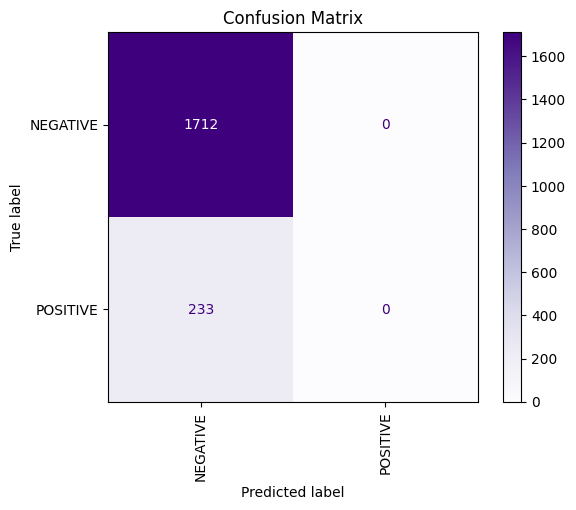

In [186]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

def evaluate_predictions(predictions, gold_labels, label_list):
    """
    Evaluate predictions against gold labels and print metrics.
    """
    predictions_flat = [label_list.index(label) for label in predictions]
    gold_labels_flat = [label_list.index(label) for label in gold_labels]

    accuracy = accuracy_score(gold_labels_flat, predictions_flat)
    report = classification_report(gold_labels_flat, predictions_flat, target_names=label_list, digits=4)

    cm = confusion_matrix(gold_labels_flat, predictions_flat, labels=list(range(len(label_list))))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
   
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    disp.plot(cmap=plt.cm.Purples, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

evaluate_predictions(new_predictions, new_labels, label_list)
